# Predict Bike Demand

In [97]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Load data

In [4]:
raw_data = pd.read_csv('train.csv', header = 0, sep = ',')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Data Fields

*datetime* - hourly date + timestamp  

*season* -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

*holiday* - whether the day is considered a holiday

*workingday* - whether the day is neither a weekend nor holiday

*weather* - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
\t 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
\t 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
\t 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

*temp* - temperature in Celsius

*atemp* - "feels like" temperature in Celsius

*humidity* - relative humidity

*windspeed* - wind speed

*casual* - number of non-registered user rentals initiated

*registered* - number of registered user rentals initiated

*count* - number of total rentals

## 2. Inspect columns

In [10]:
print(raw_data.shape) # data size

(10886, 12)


In [13]:
raw_data.isnull().values.any() # are there null values

False

In [14]:
raw_data.info() # data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


***Datetime*** column shows that this dataset is time bounded, so we need to use this column to separate train/test. In that case in our test data we will have data in future as we want to make prediction for the following demand. 
To operate datetime efficiently we should change col type to datetime and we can make additional columns with month and hour as features

In [15]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [16]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [17]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


In [19]:
train = raw_data.iloc[:-1000, :] # time dependent split
test = raw_data.iloc[-1000:, :]

In [20]:
print(raw_data.shape, train.shape, test.shape)

(10886, 14) (9886, 14) (1000, 14)


In [21]:
print('train from {} to {}'.format(train.datetime.min(), train.datetime.max()))
print('test from {} to {}'.format(test.datetime.min(), test.datetime.max()))

train from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
test from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


In [22]:

train_labels = train['count'].values
train_data = train.drop(['datetime', 'count'], axis = 1)

test_labels = test['count'].values
test_data = test.drop(['datetime', 'count'], axis = 1)

Let's check if train and test labels are equally distributed

Text(0.5, 1.0, 'test data')

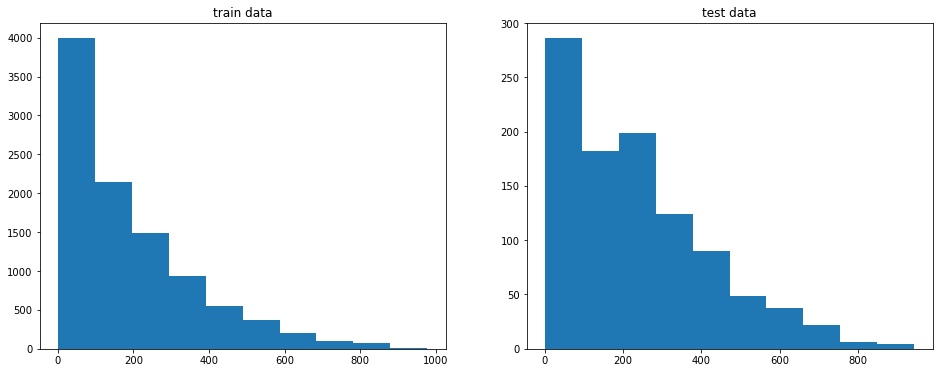

In [23]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

## 3. Separate numeric

In [25]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [26]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


## 4. Model

In [27]:
regressor = linear_model.SGDRegressor(random_state = 0) # Stochastic Gradient Descent Regressor

In [28]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

25535768020075.65

In [31]:
[round(x, 2) for x in regressor.coef_]

[-3472699008.15,
 -49597732310.17,
 -14766057546.57,
 -39425843244.52,
 -44111511991.33,
 -106968049268.24,
 12700595440.8,
 -15799785162.88]

Our linear model weights are huge. Let's try to scale features with standard scaler

## 5. Scaling

In [33]:
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [34]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.04293048301240809

Too good to be true. Lets look at weights of the model

In [36]:
[round(x, 2) for x in regressor.coef_]

[0.46, -0.45, 0.0, -0.01, 50.86, 148.01, -0.0, 0.01]

Weights near features 'casual' and 'registered' are significantly bigger than near other columns. 
The reason is that if we sum those cols we can get our target column right away.
We need to eliminate them

In [38]:
np.all(train_data.registered + train_data.casual == train_labels) # is 'casual' + 'registered' == 'count'

True

In [39]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

In [40]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [41]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.8835371361759

In [42]:
[round(x, 2) for x in regressor.coef_]

[30.01, 32.15, -42.28, 3.78, 12.71, 50.06]

Now we are going to use Cross Validation. As it has their own validation blocs we are going to use whole 'train.csv' as training data and build predictions on 'test.csv'. That prediction will be uploaded on kaggle

## Prepare data again and inspecting test dataset

In [48]:
raw_train = pd.read_csv('train.csv', header = 0, sep = ',')
raw_test = pd.read_csv('test.csv', header = 0, sep = ',')

print(raw_train.shape, raw_test.shape) # data size

(10886, 12) (6493, 9)


In [51]:
raw_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


Test data doesn't have 'casual','registered' and 'count' columns

In [53]:
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [54]:
raw_train.datetime = raw_train.datetime.apply(pd.to_datetime)
raw_test.datetime = raw_test.datetime.apply(pd.to_datetime)


In [55]:
raw_train['month'] = raw_train.datetime.apply(lambda x : x.month)
raw_train['hour'] = raw_train.datetime.apply(lambda x : x.hour)

raw_test['month'] = raw_test.datetime.apply(lambda x : x.month)
raw_test['hour'] = raw_test.datetime.apply(lambda x : x.hour)

In [56]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed',  'month', 'hour']

In [60]:
train_data = raw_train[numeric_columns]
train_labels = raw_train['count']
test_data = raw_test[numeric_columns]
train_data.head()

,temp,atemp,humidity,windspeed,month,hour
0,9.84,14.395,81,0.0,1,0
1,9.02,13.635,80,0.0,1,1
2,9.02,13.635,80,0.0,1,2
3,9.84,14.395,75,0.0,1,3
4,9.84,14.395,75,0.0,1,4


## 6. Pipeline

In [66]:
pipeline = Pipeline(steps = [('scaling', StandardScaler()), ('regression', linear_model.SGDRegressor(random_state = 0))])

In [67]:
pipeline.fit(train_data, train_labels)

Pipeline(steps=[('scaling', StandardScaler()),
                ('regression', SGDRegressor(random_state=0))])

In [68]:
predictions = pipeline.predict(test_data)

output = pd.DataFrame({'datetime': raw_test.datetime, 'count': predictions})
output.to_csv('standard_scaler_SGDregr.csv', index=False)


## Grid search

In [70]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])

In [71]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [72]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [73]:
grid_cv.fit(train_data, train_labels)

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stoc

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('regression',
                                        SGDRegressor(random_state=0))]),
             param_grid={'regression__alpha': [0.0001, 0.01],
                         'regression__loss': ['huber', 'epsilon_insensitive',
                                              'squared_loss'],
                         'regression__max_iter': [3, 5, 10, 50],
                         'regression__penalty': ['l1', 'l2', 'none'],
                         'scaling__with_mean': [0.0, 0.5]},
             scoring='neg_mean_absolute_error')

In [74]:
print( grid_cv.best_score_)
print( grid_cv.best_params_)

-112.37843444008034
{'regression__alpha': 0.0001, 'regression__loss': 'epsilon_insensitive', 'regression__max_iter': 50, 'regression__penalty': 'none', 'scaling__with_mean': 0.0}


In [75]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [79]:
test_predictions = [0 if x<0 else x for x in test_predictions]

In [80]:
test_predictions

[3.422489779212268,
 0,
 1.3545659401344055,
 15.85176933948184,
 22.893082365605785,
 19.51378954646307,
 21.641740681093335,
 37.13452041527964,
 47.71896329159146,
 61.201388383858614,
 82.04030455263401,
 95.67370192990616,
 109.83692764195774,
 108.51755883727526,
 122.22567096675306,
 137.72347573455852,
 129.54712365255105,
 137.1241999043258,
 123.24006221099928,
 133.66430742537935,
 133.5748164122057,
 133.94339544410445,
 132.0034134273866,
 141.70355756386925,
 0,
 0,
 0,
 0,
 0,
 26.433916694035734,
 31.86180486881396,
 40.23626130291273,
 56.69757880584529,
 58.74631594517762,
 76.46156286078707,
 98.5428375602814,
 136.33451706935568,
 146.31502781614978,
 143.052037625636,
 134.1640652049412,
 138.19207671565678,
 136.9394411670621,
 131.78920536322994,
 140.97468143273122,
 141.05427943485924,
 129.0645661265314,
 127.73003705405077,
 138.60346096013333,
 0,
 0,
 0,
 0,
 0,
 0,
 3.330297866927442,
 10.72608129810104,
 25.607473197178688,
 31.930620036276583,
 47.181642

In [81]:
output = pd.DataFrame({'datetime': raw_test.datetime, 'count': test_predictions})
output.to_csv('standard_scaler_SGDregr_CV.csv', index=False)

In [82]:
grid_cv.best_score_

-112.37843444008034

# Random forest classifier

In [84]:
from sklearn.ensemble import RandomForestRegressor

In [85]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [92]:
train_labels = raw_train['count'].values
train_data = raw_train.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)
test_data = raw_test.drop(['datetime'], axis = 1)

In [94]:
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour
0,1,0,0,1,9.84,14.395,81,0.0,1,0
1,1,0,0,1,9.02,13.635,80,0.0,1,1
2,1,0,0,1,9.02,13.635,80,0.0,1,2
3,1,0,0,1,9.84,14.395,75,0.0,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,4


In [95]:
binary_data_columns = ['holiday', 'workingday']

categorical_data_columns = ['season', 'weather', 'month'] 

numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']



In [98]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[binary_data_columns])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[numeric_data_columns])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[categorical_data_columns])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [99]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x7f87b0c69820>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7f87b0c695e0>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7f87b0c69310>)),
  

In [105]:
sum([estimator.predict(test_data)<0])

0

In [106]:
output = pd.DataFrame({'datetime': raw_test.datetime, 'count': estimator.predict(test_data)})
output.to_csv('pipeline_random_forest.csv', index=False)

In [112]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__verbose', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__check_inverse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__verbose'

In [113]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}